In [140]:
# load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
# Load all MLB data and combine/merge them into one table

In [3]:
pitches = pd.read_csv("archive/pitches.csv")

In [4]:
atbats = pd.read_csv('archive/atbats.csv')

In [5]:
games = pd.read_csv('games.csv') 

In [6]:
names = pd.read_csv('archive/player_names.csv')

In [7]:
# Merging pitches and atbats by ab_id
data = pd.merge(pitches, atbats, on = 'ab_id', how = 'left')

In [8]:
# Merging games data with pitches and atbats by g_id
data = pd.merge(data, games, on = 'g_id', how = 'left')

In [9]:
data1 = data.g_id.astype('str')

In [10]:
# Since the year is the first four characters, we will isolate those characters
data1 = data1.str[:4]

In [11]:
data['year'] = data1.values

In [12]:
data17 = data[data['year'] == '2017']

In [13]:
data17 = pd.merge(data17, names, left_on = 'pitcher_id', right_on = 'id')

In [14]:
data17.to_csv("data17.csv")

In [ ]:
# start from below, if data17.csv is ready

In [5]:
data17 = pd.read_csv("data17.csv")

In [102]:
data17_merge = pd.DataFrame(data17[['pitch_type', 'pitcher_id']])

In [110]:
# drop the outliers
data17_merge = data17_merge[data17_merge.pitch_type != 'AB']
data17_merge = data17_merge[data17_merge.pitch_type != 'UN']
data17_merge = data17_merge[data17_merge.pitch_type != 'EP']
data17_merge = data17_merge[data17_merge.pitch_type != 'SC']
data17_merge = data17_merge[data17_merge.pitch_type != 'PO']
data17_merge = data17_merge[data17_merge.pitch_type != 'FO']

In [138]:
data17_merge.dropna(inplace=True) # now it will actually drop the nan values

In [105]:
data17_merge.pitch_type.value_counts()

FF    253387
SL    117643
FT     96280
CH     71529
CU     58559
SI     50423
FC     36822
KC     19143
FS     11761
KN      2650
Name: pitch_type, dtype: int64

In [171]:
pitcherid=set()
for i in data17_merge.pitcher_id:
    pitcherid.add(i)

In [11]:
pitcherid

{112526,
 276351,
 276520,
 276542,
 279571,
 282332,
 285079,
 407793,
 407822,
 407845,
 408061,
 424144,
 425386,
 425492,
 425794,
 425844,
 429719,
 429722,
 430589,
 430599,
 430641,
 430661,
 430912,
 430935,
 430947,
 432934,
 433217,
 433586,
 433587,
 433589,
 434378,
 434442,
 434538,
 434563,
 434622,
 434628,
 434671,
 434672,
 434718,
 435043,
 435221,
 435400,
 444468,
 444520,
 444857,
 445055,
 445060,
 445197,
 445213,
 445276,
 445926,
 446099,
 446372,
 446399,
 446899,
 447714,
 448179,
 448281,
 448306,
 448609,
 448614,
 448802,
 448855,
 449173,
 450172,
 450203,
 450212,
 450282,
 450306,
 450308,
 450729,
 451584,
 451596,
 451661,
 452027,
 452657,
 452666,
 452718,
 453172,
 453178,
 453192,
 453214,
 453265,
 453281,
 453284,
 453286,
 453329,
 453343,
 453344,
 453385,
 453562,
 455009,
 455374,
 455376,
 456034,
 456068,
 456167,
 456379,
 456501,
 456696,
 456701,
 456713,
 457117,
 457429,
 457732,
 457768,
 457915,
 457918,
 458006,
 458584,
 458676,
 

modified version of proportion calculator (faster)

In [210]:
new_17 = pd.DataFrame()
new_17['pitcher_id'] = [i for i in pitcherid]
new_17

,pitcher_id
0,466948
1,456713
2,622608
3,501789
4,596001
...,...
750,489446
751,628711
752,475115
753,456696


In [211]:
# for indexing purpose, create a dictionary {pitcher_id: index}
pitcher_locator = dict()
for i, row in new_17.iterrows():
    pitcher_locator[int(row['pitcher_id'])] = i

In [212]:
# Get the pitch type proportion for each pitcher, from 2017 data
index = data17_merge.index
new_17['FF'] = 0
new_17['SL'] = 0
new_17['FT'] = 0
new_17['CH'] = 0
new_17['CU'] = 0
new_17['SI'] = 0
new_17['FC'] = 0
new_17['KC'] = 0
new_17['FS'] = 0
new_17['KN'] = 0

In [213]:
start = dt.datetime.now()
print("Start:", start)
for _, row in data17_merge.iterrows():
    # print(row['pitcher_id'], row['pitch_type'])
    # print(pitcher_locator[row['pitcher_id']])
    #print(row['pitch_type'])
    # print("this", pitcher_locator[row['pitcher_id']], row['pitch_type'])
    new_17.loc[pitcher_locator[row['pitcher_id']], str(row['pitch_type'])] += 1
print("End:", dt.datetime.now())
print()
print("It took...", dt.datetime.now() - start)

Start: 2021-08-12 22:32:21.810774
End: 2021-08-12 22:36:36.517654

It took... 0:04:14.707877


In [225]:
proportion = new_17.iloc[:, 1:].div(new_17.iloc[:, 1:].sum(axis=1), axis=0)

In [231]:
proportion['pitcher_id'] = [i for i in pitcherid]
cols = proportion.columns.tolist()
cols = cols[-1:] + cols[:-1]
proportion = proportion[cols]

In [232]:
proportion

,pitcher_id,FF,SL,FT,CH,CU,SI,FC,KC,FS,KN
0,466948,0.476636,0.009346,0.056075,0.355140,0.102804,0.00000,0.000000,0.000000,0.000000,0.0
1,456713,0.451271,0.047669,0.240466,0.001059,0.137712,0.00000,0.121822,0.000000,0.000000,0.0
2,622608,0.720416,0.221771,0.000000,0.027100,0.030714,0.00000,0.000000,0.000000,0.000000,0.0
3,501789,0.265367,0.000000,0.000000,0.000000,0.311844,0.00000,0.422789,0.000000,0.000000,0.0
4,596001,0.209730,0.339250,0.000000,0.069034,0.037475,0.34451,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
750,489446,0.536534,0.266180,0.088727,0.000000,0.000000,0.00000,0.000000,0.000000,0.108559,0.0
751,628711,0.466019,0.135922,0.058252,0.252427,0.087379,0.00000,0.000000,0.000000,0.000000,0.0
752,475115,0.466874,0.349896,0.181159,0.002070,0.000000,0.00000,0.000000,0.000000,0.000000,0.0
753,456696,0.273183,0.249373,0.245614,0.000000,0.231830,0.00000,0.000000,0.000000,0.000000,0.0


In [234]:
proportion.to_csv("proportion.csv")

In [188]:
new_17.iloc[:, 1:]

,FF,SL,FT,CH,CU,SI,FC,KC,FS,KN
0,51,1,6,38,11,0,0,0,0,0
1,426,45,227,1,130,0,115,0,0,0
2,1595,491,0,60,68,0,0,0,0,0
3,177,0,0,0,208,0,282,0,0,0
4,319,516,0,105,57,524,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
750,514,255,85,0,0,0,0,0,104,0
751,192,56,24,104,36,0,0,0,0,0
752,451,338,175,2,0,0,0,0,0,0
753,218,199,196,0,185,0,0,0,0,0


old version of proportion calculator

In [235]:
# Get the pitch type proportion for each pitcher, from 2017 data
start = dt.datetime.now()
print("Start:", start)
FF = 0
SL = 0
FT = 0
CH = 0
CU = 0
SI = 0
FC = 0
KC = 0
FS = 0
KN = 0
index = data17_merge.index
tempid = ""
count = 0
new_17['FF'] = np.nan
new_17['SL'] = np.nan
new_17['FT'] = np.nan
new_17['CH'] = np.nan
new_17['CU'] = np.nan
new_17['SI'] = np.nan
new_17['FC'] = np.nan
new_17['KC'] = np.nan
new_17['FS'] = np.nan
new_17['KN'] = np.nan
for j in pitcherid:
    for i in index:
        if data17_merge.loc[i, "pitcher_id"] == j:     
            if data17_merge.loc[i, "pitch_type"] == "FF":
                FF += 1
            elif data17_merge.loc[i, "pitch_type"] == "SL":
                SL += 1
            elif data17_merge.loc[i, "pitch_type"] == "FT":
                FT += 1
            elif data17_merge.loc[i, "pitch_type"] == "CH":
                CH += 1
            elif data17_merge.loc[i, "pitch_type"] == "CU":
                CU += 1
            elif data17_merge.loc[i, "pitch_type"] == "SI":
                SI += 1
            elif data17_merge.loc[i, "pitch_type"] == "FC":
                FC += 1
            elif data17_merge.loc[i, "pitch_type"] == "KC":
                KC += 1
            elif data17_merge.loc[i, "pitch_type"] == "FS":
                FS += 1
            elif data17_merge.loc[i, "pitch_type"] == "KN":
                KN += 1
    total = FF+SL+FT+CH+CU+SI+KC+FS+KN+FC
    new_17.loc[count, "FF"] = FF/total
    new_17.loc[count, "SL"] = SL/total
    new_17.loc[count, "FT"] = FT/total
    new_17.loc[count, "CH"] = CH/total
    new_17.loc[count, "CU"] = CU/total
    new_17.loc[count, "SI"] = SI/total
    new_17.loc[count, "FC"] = FC/total
    new_17.loc[count, "KC"] = KC/total
    new_17.loc[count, "FS"] = FS/total
    new_17.loc[count, "KN"] = KN/total
    FF = 0
    SL = 0
    FT = 0
    CH = 0
    CU = 0
    SI = 0
    FC = 0
    KC = 0
    FS = 0
    KN = 0
    count+=1
print("End:", dt.datetime.now())
print()
print("It took...", dt.datetime.now() - start)

Start: 2021-08-12 22:41:36.281011
End: 2021-08-13 00:12:45.132708

It took... 1:31:08.862177


In [24]:
data17_merge.loc[724615, "pitch_type"]

'SL'

In [25]:
data17_merge

,pitch_type,pitcher_id
0,FF,593372
1,FT,593372
2,FT,593372
3,SL,593372
4,FT,593372
...,...,...
724613,FT,622492
724614,FF,622492
724615,SL,622492
724616,FF,622492


In [26]:
# export the pitch type proportion for each pitcher, from 2017 data, into a new csv file
new_17.to_csv("new_17.csv")

In [27]:
new_17 = pd.read_csv("new_17.csv")

In [28]:
# Using only 2018 year
data18 = data[data['year'] == '2018']

In [57]:
new_17

,pitcher_id,FF,SL,FT,CH,CU,SI,FC,KC,FS,KN
0,466948,0,0,0,0,0,0,0,0,0,0
1,456713,0,0,0,0,0,0,0,0,0,0
2,622608,0,0,0,0,0,0,0,0,0,0
3,501789,0,0,0,0,0,0,0,0,0,0
4,596001,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
750,489446,0,0,0,0,0,0,0,0,0,0
751,628711,0,0,0,0,0,0,0,0,0,0
752,475115,0,0,0,0,0,0,0,0,0,0
753,456696,0,0,0,0,0,0,0,0,0,0


In [17]:
new_17.loc[0, "pitcher_id"]

466948

In [29]:
# Merging the data with names
data18 = pd.merge(data18, names, left_on = 'pitcher_id', right_on = 'id')

In [30]:
# Making speed as numeric
data18['speed'] = data18['speed'].str[:-3]
data18['speed'] = data18.speed.astype('int')

In [31]:
# Changing to numeric
from sklearn.preprocessing import LabelEncoder
number = LabelEncoder()
data18['venue_name'] = number.fit_transform(data18['venue_name'])
data18['condition'] = number.fit_transform(data18['condition'])

In [32]:
# function that is used to label:
# 1 if the wind condition is in advantage of hitter (Out);
# 2 if the wind condition is in advantage of pitcher (In);
# 0 if neutral
def wind_direction(row):
    if row['direction'][:1] == 'O':
        return 1
    elif row['direction'][:1] == 'I':
        return 2
    else:
        return 0

In [33]:
# Changind dirction value to 0,1,2
data18['direction'] = data18.apply(wind_direction, axis=1)

In [34]:
# do the same for pitch codes

In [68]:
data17['code']

0         B
1         F
2         B
3         D
4         C
         ..
724613    B
724614    B
724615    C
724616    B
724617    X
Name: code, Length: 724618, dtype: object

In [83]:
# function that is used to label:
# 1 if in-play; out,
# 2 if in-play; no out,
# 3 if in-play; runs,
# 4 if hit by pitch,
# 0 if else
def last_pitch(row):
    if row['code'] == 'X':
        return 1
    elif row['code'] == 'D':
        return 2
    elif row['code'] == 'E':
        return 3
    elif row['code'] == 'H':
        return 4
    else:
        return 0

In [84]:
data18['code'] = data18.apply(last_pitch, axis=1)

In [90]:
data18['code'].value_counts()

0    596228
1     81801
2     28526
3     15967
4      1922
Name: code, dtype: int64

In [91]:
new_data = pd.DataFrame(data18[['pitch_type', 'b_score', 's_count', 'outs', 'pitch_num', \
                            'on_1b', 'on_2b', 'on_3b', 'batter_id', 'inning', 'p_score', 'p_throws',\
                             'pitcher_id', 'stand', 'top', 'b_count',\
                          'venue_name','speed', 'direction',\
                          'temperature', 'condition', 'code']])

In [92]:
pXs = new_data.to_csv("pXs.csv")

Now we can get more specific with our scrubbing to further clean our dataset. We will create a new DataFrame called pXs (pitch X situation) and reduce our columns to game situational data. As much of the pitches file is individual statistics on the pitch thrown, it would defeat the purpose of attempting to predict a pitch if the data of the pitch was provided.

In [93]:
pXs = pd.read_csv("pXs.csv", index_col=[0])

In [94]:
pXs = pd.merge(pXs, new_17, on = 'pitcher_id')

In [95]:
pXs.isnull().sum()

pitch_type     4990
b_score           0
s_count           0
outs              0
pitch_num         0
on_1b             0
on_2b             0
on_3b             0
batter_id         0
inning            0
p_score           0
p_throws          0
pitcher_id        0
stand             0
top               0
b_count           0
venue_name        0
speed             0
direction         0
temperature       0
condition         0
code              0
Unnamed: 0        0
FF                0
SL                0
FT                0
CH                0
CU                0
SI                0
FC                0
KC                0
FS                0
KN                0
dtype: int64

In [96]:
# Drop that has null pitch_type
pXs = pXs.dropna()

In [97]:
# Changing values to numeric
pXs.p_throws = pXs.p_throws.replace(['R', 'L'], [0,1])
pXs.stand = pXs.stand.replace(['R', 'L'], [0,1])
pXs.top = pXs.top.replace([True, False], [1,0])

In [98]:
pXs.pitch_type.value_counts()

FF    209662
SL    104247
FT     74277
CH     64540
CU     50112
SI     48013
FC     34329
KC     15992
FS      8985
KN       719
EP       203
FO        84
PO        77
SC        37
AB         1
Name: pitch_type, dtype: int64

In [99]:
# Deleting pitch types that have low value counts
pXs = pXs[pXs.pitch_type != 'AB']
pXs = pXs[pXs.pitch_type != 'UN']
pXs = pXs[pXs.pitch_type != 'EP']
pXs = pXs[pXs.pitch_type != 'SC']
pXs = pXs[pXs.pitch_type != 'PO']
pXs = pXs[pXs.pitch_type != 'FO']

In [100]:
# Recency Feature
from sklearn.preprocessing import LabelEncoder
def recency(depth):
    number = LabelEncoder()
    for a in range(depth):
        pXs["t-"+str(a+1)+" pitch_type"] = np.nan
    index = pXs.index 
    print(index)
    for j in range(len(index)-depth):
        if pXs.loc[index[j+depth], "pitcher_id"] == pXs.loc[index[j], "pitcher_id"]:
            for c in range(depth):
                past = pXs.loc[index[j+depth-c-1]]
                pXs.loc[index[j+depth], "t-"+str(c+1)+" pitch_type"] = past.pitch_type
    for d in range(depth):
        pXs['t-'+str(d+1)+' pitch_type'] = pXs['t-'+str(d+1)+' pitch_type'].astype('str')             
        pXs['t-'+str(d+1)+' pitch_type'] = number.fit_transform(pXs['t-'+str(d+1)+' pitch_type'])
recency(3)

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            616258, 616259, 616260, 616261, 616262, 616263, 616264, 616265,
            616266, 616267],
           dtype='int64', length=610876)


KeyboardInterrupt: 

In [45]:
pXs.to_csv("recency_feature.csv")

In [46]:
pXs.head(20)

,pitch_type,b_score,s_count,outs,pitch_num,on_1b,on_2b,on_3b,batter_id,inning,...,CH,CU,SI,FC,KC,FS,KN,t-1 pitch_type,t-2 pitch_type,t-3 pitch_type
0,SI,0.0,0.0,0.0,1.0,0.0,0.0,0.0,446359,1,...,0.106843,0.0,0.663866,0.138055,0.0,0.0,0.0,10,10,10
1,SI,0.0,1.0,0.0,2.0,0.0,0.0,0.0,446359,1,...,0.106843,0.0,0.663866,0.138055,0.0,0.0,0.0,10,10,10
2,SI,0.0,1.0,0.0,3.0,0.0,0.0,0.0,446359,1,...,0.106843,0.0,0.663866,0.138055,0.0,0.0,0.0,10,10,10
3,SL,0.0,2.0,0.0,4.0,0.0,0.0,0.0,446359,1,...,0.106843,0.0,0.663866,0.138055,0.0,0.0,0.0,8,8,8
4,SI,0.0,2.0,0.0,5.0,0.0,0.0,0.0,446359,1,...,0.106843,0.0,0.663866,0.138055,0.0,0.0,0.0,9,8,8
5,SI,0.0,0.0,1.0,1.0,0.0,0.0,0.0,545361,1,...,0.106843,0.0,0.663866,0.138055,0.0,0.0,0.0,8,9,8
6,FF,0.0,1.0,1.0,2.0,0.0,0.0,0.0,545361,1,...,0.106843,0.0,0.663866,0.138055,0.0,0.0,0.0,8,8,9
7,FC,0.0,1.0,1.0,3.0,0.0,0.0,0.0,545361,1,...,0.106843,0.0,0.663866,0.138055,0.0,0.0,0.0,3,8,8
8,SI,0.0,2.0,1.0,4.0,0.0,0.0,0.0,545361,1,...,0.106843,0.0,0.663866,0.138055,0.0,0.0,0.0,2,3,8
9,SI,0.0,0.0,2.0,1.0,0.0,0.0,0.0,457708,1,...,0.106843,0.0,0.663866,0.138055,0.0,0.0,0.0,8,2,3


In [47]:
df = pXs

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 610876 entries, 0 to 616267
Data columns (total 35 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   pitch_type      610876 non-null  object 
 1   b_score         610876 non-null  float64
 2   s_count         610876 non-null  float64
 3   outs            610876 non-null  float64
 4   pitch_num       610876 non-null  float64
 5   on_1b           610876 non-null  float64
 6   on_2b           610876 non-null  float64
 7   on_3b           610876 non-null  float64
 8   batter_id       610876 non-null  int64  
 9   inning          610876 non-null  int64  
 10  p_score         610876 non-null  int64  
 11  p_throws        610876 non-null  int64  
 12  pitcher_id      610876 non-null  int64  
 13  stand           610876 non-null  int64  
 14  top             610876 non-null  int64  
 15  b_count         610876 non-null  float64
 16  venue_name      610876 non-null  int64  
 17  speed     

In [49]:
features = pXs.drop('pitch_type', axis=1)

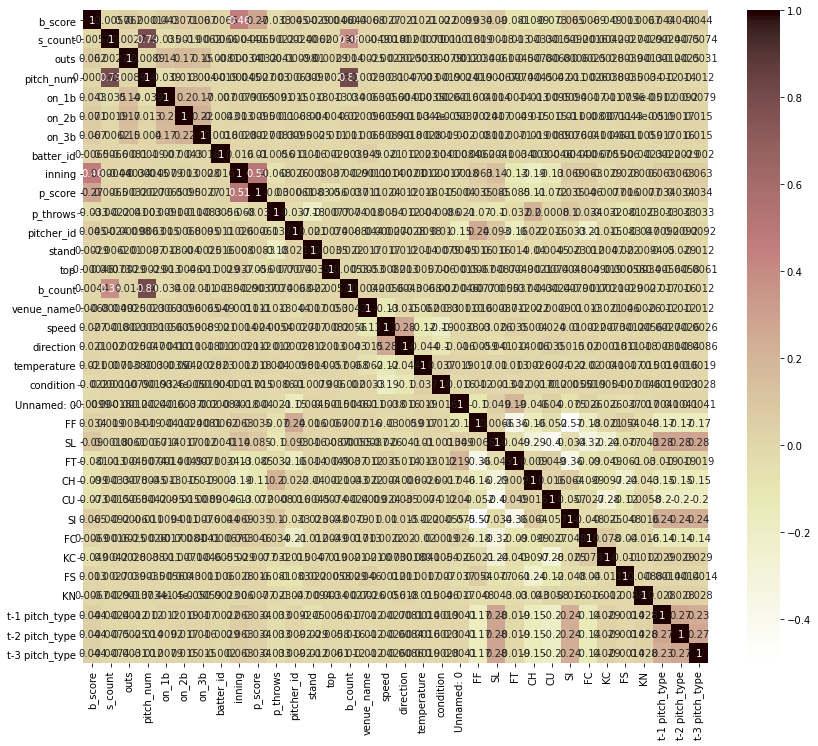

In [50]:
correlation = features.corr() 
plt.figure(figsize=(14,12)) 
heatmap = sns.heatmap(correlation, annot=True, linewidths = 0, vmin=-.5, cmap='pink_r')

In [51]:
# Drop pitch_num by looking at the correlation plots 
# pitch_num has strong correlation with b_count, s_count
features = features.drop('pitch_num', axis=1)

In [52]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 610876 entries, 0 to 616267
Data columns (total 33 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   b_score         610876 non-null  float64
 1   s_count         610876 non-null  float64
 2   outs            610876 non-null  float64
 3   on_1b           610876 non-null  float64
 4   on_2b           610876 non-null  float64
 5   on_3b           610876 non-null  float64
 6   batter_id       610876 non-null  int64  
 7   inning          610876 non-null  int64  
 8   p_score         610876 non-null  int64  
 9   p_throws        610876 non-null  int64  
 10  pitcher_id      610876 non-null  int64  
 11  stand           610876 non-null  int64  
 12  top             610876 non-null  int64  
 13  b_count         610876 non-null  float64
 14  venue_name      610876 non-null  int64  
 15  speed           610876 non-null  int64  
 16  direction       610876 non-null  int64  
 17  temperatur

In [53]:
# y value = pitch_type
target = df['pitch_type']

In [54]:
example = features

In [55]:
target_e = target

In [56]:
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score
import xgboost as xgb
import random
from sklearn.model_selection import GridSearchCV

In [57]:
#splitting the train and test data for the XGB model
X_train, X_test, y_train, y_test = train_test_split(example, target_e, test_size=0.10, random_state = 77777)
#create xgb instance out of the box
clf = xgb.XGBClassifier(eval_metric='mlogloss')
#fit data
clf.fit(X_train, y_train)
#make predictions
training_preds = clf.predict(X_train)
val_preds = clf.predict(X_test)
#run classification report and confusion matrix
gbt_confusion_matrix = confusion_matrix(y_test, val_preds)
print(gbt_confusion_matrix)
gbt_classification_report = classification_report(y_test, val_preds)
print(gbt_classification_report)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[[ 1126   169   221  2998    14   789    78     0   759   356]
 [  203   800   235  2490    16   557     0     3   419   301]
 [  164   108  1318  1012    19   342   114     0   259    81]
 [  597   456   482 15675   230  1048   179     2   387  1975]
 [    1    10    10   409   348    55     7     0    18    53]
 [  244   225   230  1705    25  3868    81     0     0   873]
 [   43     0    45   671    15   114   495     0   141    40]
 [    0     1     0     0     0     0     0    71     0     0]
 [  202   101   108   282    10     0    68     0  3793   324]
 [  171   119   161  4322    45  1109    29     0   829  3635]]
              precision    recall  f1-score   support

          CH       0.41      0.17      0.24      6510
          CU       0.40      0.16      0.23      5024
          FC       0.47      0.39      0.42      3417
          FF       0.53      0.75      0.62     21031
          FS       0.48      0.38      0.43       911
          FT       0.49      0.53      0.51 

In [58]:
# Doesn't work with n_jobs=-1. 
# 만약 계속 안되면 n_jobs=1로 해보셈
clf = xgb.XGBClassifier(eval_metric='mlogloss')
#clf.fit(X_train, y_train)
Xgb_train, Xgb_test, yxgb_train, yxgb_test = train_test_split(example, target_e, test_size=0.10, random_state = 77777)
xgb_param_grid = {"learning_rate": [0.1,1],'max_depth': [2,6],'min_child_weight': [5,10],'n_estimators': [50, 100]}
gs = GridSearchCV(clf, xgb_param_grid, n_jobs=1, cv=3)
gs.fit(Xgb_train, yxgb_train)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample

In [59]:
gs.best_params_

{'learning_rate': 1,
 'max_depth': 6,
 'min_child_weight': 10,
 'n_estimators': 50}

In [60]:
# put the parameter inside XGBClassifier that u got from gs.best_param
X_train, X_test, y_train, y_test = train_test_split(example, target_e, test_size=0.10, random_state = 77777)
#create xgb instance with parameters
clf = xgb.XGBClassifier(learning_rate=1,max_depth=6,min_child_weight=10,n_estimators=50)
#fit data
clf.fit(X_train, y_train)
#make predictions
training_preds = clf.predict(X_train)
val_preds = clf.predict(X_test)
#run classification report and confusion matrix
gbt_confusion_matrix = confusion_matrix(y_test, val_preds)
print(gbt_confusion_matrix)
gbt_classification_report = classification_report(y_test, val_preds)
print(gbt_classification_report)

[05:41:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[ 1374   216   258  2741     7   752    86     0   679   397]
 [  227  1018   242  2266    24   552     0     3   361   331]
 [  186   132  1369   927    18   310   124     0   246   105]
 [  730   617   546 15014   286  1024   268     2   351  2193]
 [    4    12    12   357   376    63    12     0    16    59]
 [  314   272   276  1535    23  3832    93     0     0   906]
 [   52     0    64   632    15   109   528     0   124    40]
 [    0     2     0     0     0     0     0    70     0     0]
 [  239   151   141   282    16     0    78     0  3595   386]
 [  245   159   161  3951    62  1113    51     0   762  3916]]
              precision    recall  f1-score   support

   

In [61]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 610876 entries, 0 to 616267
Data columns (total 33 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   b_score         610876 non-null  float64
 1   s_count         610876 non-null  float64
 2   outs            610876 non-null  float64
 3   on_1b           610876 non-null  float64
 4   on_2b           610876 non-null  float64
 5   on_3b           610876 non-null  float64
 6   batter_id       610876 non-null  int64  
 7   inning          610876 non-null  int64  
 8   p_score         610876 non-null  int64  
 9   p_throws        610876 non-null  int64  
 10  pitcher_id      610876 non-null  int64  
 11  stand           610876 non-null  int64  
 12  top             610876 non-null  int64  
 13  b_count         610876 non-null  float64
 14  venue_name      610876 non-null  int64  
 15  speed           610876 non-null  int64  
 16  direction       610876 non-null  int64  
 17  temperatur

In [ ]:
# XGBoost with multi:softprob option

In [82]:
le = LabelEncoder()
le.fit(target)
target_num = le.transform(target)
# list(le.inverse_transform(target_num)) #If you wish to retrieve the original descriptive labels post production

X_train, X_test, y_train, y_test = train_test_split(features, target_num, test_size=0.3, random_state=42)

# use DMatrix for xgboost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
fit = xgb.XGBClassifier(objective = 'multi:softprob', eval_metric = 'merror')
fit.fit(X_train,y_train)

# set xgboost params
param = {
'max_depth': 10,  # the maximum depth of each tree
'learning_rate': 0.1,  # the training step for each iteration
'min_child_weight': 20,
'n_estimators': 300,
'objective': 'multi:softprob',  # error evaluation for multiclass training
'eval_metric': 'merror', # ADDED
'num_class': 10}  # the number of classes that exist in this datset
num_rounds=30

#------------- numpy array ------------------

#training and testing - numpy matrices
bst = xgb.train(param, dtrain,num_rounds)
preds = bst.predict(dtest)

#extracting most confident predictions
best_preds = np.asarray([np.argmax(line) for line in preds])
print ("Numpy array test precision:", precision_score(y_test, best_preds, average='macro'))

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:33:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Numpy array test precision: 0.5232267189845994


In [85]:
xgb_param_grid = {'max_depth': [10,13],'min_child_weight': [15,20] \
                  ,'n_estimators': [250,300], 'num_rounds': [30,60,90]}
gs = GridSearchCV(fit, xgb_param_grid, n_jobs=-1, cv=3)
gs.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:55:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "num_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, eval_metric='merror',
                                     gamma=0, gpu_id=-1, importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=8,
                                     num_parallel_tree=1,
                                     objective='multi:softprob', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=None, subsample=1,


In [101]:
gs.best_params_

{'min_child_weight': 25, 'n_estimators': 300, 'num_rounds': 20}

In [102]:
preds.shape

(183263, 10)

In [103]:
print(preds[:7])

[[0.05595633 0.01677946 0.18191825 0.03190362 0.01670158 0.01673831
  0.07882542 0.01669664 0.44695723 0.13752314]
 [0.06287042 0.04217982 0.01685084 0.09109869 0.01643136 0.01646749
  0.01643112 0.0164265  0.54649025 0.17475352]
 [0.10037227 0.10501245 0.01917703 0.02723938 0.01869964 0.01874077
  0.01869937 0.01869411 0.45394582 0.21941917]
 [0.00772709 0.00763166 0.00803848 0.89860433 0.00759515 0.00808395
  0.03948868 0.0075929  0.00759471 0.00764305]
 [0.19711322 0.02022985 0.02029366 0.02606349 0.02012324 0.02016749
  0.02012295 0.02011729 0.51694155 0.1388273 ]
 [0.10777041 0.12861836 0.01949704 0.11280444 0.01919832 0.43537122
  0.01919805 0.01919265 0.01919722 0.11915228]
 [0.03709812 0.06873842 0.01981316 0.34866235 0.0195096  0.13433266
  0.01950932 0.01950383 0.01950847 0.31332412]]


In [104]:
#creating a dataframe for plotting purposes
plot = pd.DataFrame(data=preds[:,:], columns=['Changeup', 'Curveball', 'Cutter', 'Fastball_4S', \
                          'Splitter', 'Fastball_2S', 'Knucklecurve', 'Knuckleball', 'Sinker', \
                                              'Slider'])

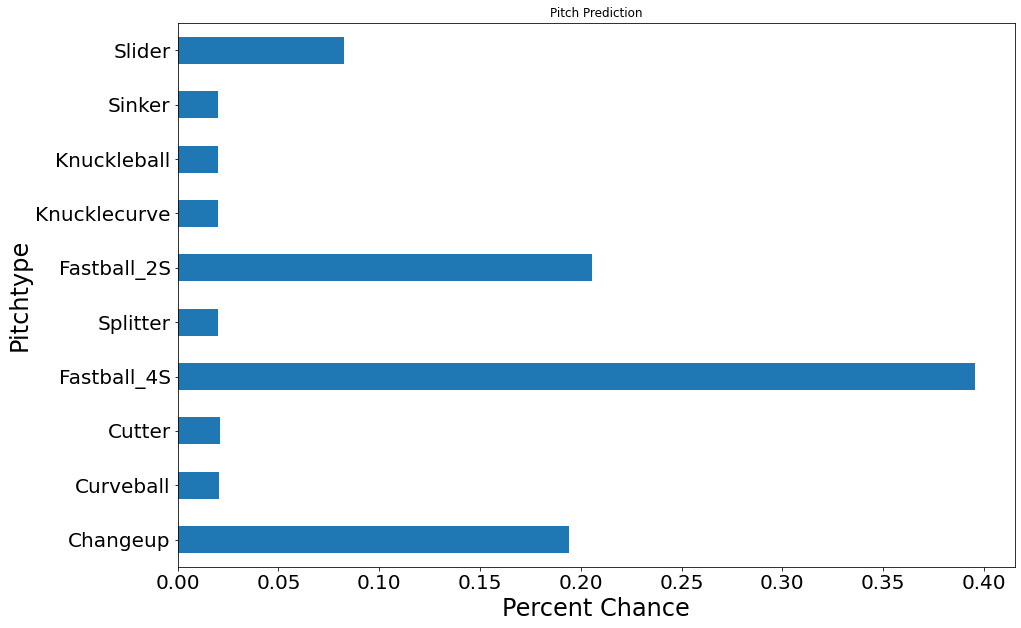

In [105]:
ax = plot.iloc[23].plot(kind='barh',title ="Pitch Prediction", figsize=(15, 10), fontsize=20)
ax.set_xlabel("Percent Chance", fontsize=24)
ax.set_ylabel("Pitchtype", fontsize=24)
plt.show()

In [62]:
# KNN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
X_train, X_test, y_train, y_test = train_test_split(example, target_e, test_size=0.10, random_state = 77777)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
test_error = []
# Calculating error for K values of 1,4,9,16,25,36,49,64,81,100
for i in range(1, 50):
    #print(i**2)
    print(i)
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    test_error.append(np.mean(pred_i != y_test))
a = min(test_error)
for i in range(0,len(test_error)):
    if test_error[i]==a:
        print(i)

1
2
3
4
5
6
7


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 50), test_error, color='grey', linestyle='dashed', marker='o', 
         markerfacecolor='black', markersize=7, label='Testing Set Error Rate')
plt.legend(fontsize = 15)
plt.title('Error Rate K Value', fontsize = 20)
plt.xlabel('K Value', fontsize = 15)
plt.ylabel('Error Rate', fontsize = 15)

In [ ]:
print(a)

In [63]:
# Put the number that you got from KNN to n_neighbors
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=11)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=11)

In [64]:
y_pred = classifier.predict(X_test)

In [65]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred,zero_division=True))

[[ 1434   302   260  2603     6   696    83     0   699   427]
 [  401   965   241  2286    17   487     0     3   366   258]
 [  307   198  1315   912    11   255   101     0   219    99]
 [ 1309   972   646 14132   211  1043   256     2   297  2163]
 [    7    23    12   472   247    60     7     0    22    61]
 [  575   437   266  1695    24  3330    78     0     1   845]
 [   89     0   109   633    11   123   430     0   123    46]
 [    0     0     0     0     0     0     0    72     0     0]
 [  363   180   164   308    12     1    80     0  3416   364]
 [  355   249   170  4537    57  1157    49     0   861  2985]]
              precision    recall  f1-score   support

          CH       0.30      0.22      0.25      6510
          CU       0.29      0.19      0.23      5024
          FC       0.41      0.38      0.40      3417
          FF       0.51      0.67      0.58     21031
          FS       0.41      0.27      0.33       911
          FT       0.47      0.46      0.46 

In [66]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.4636917234154007


In [67]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_test, y_test)

accuracy_score(y_train, model.predict(X_train))

0.3032186952061522

In [77]:
#creating a dataframe for plotting purposes
plot = pd.DataFrame(data=val_preds[:,:], columns=['Changeup', 'Curveball', 'Cutter', 'Fastball_4S', 'Splitter', 'Fastball_2S', 'Knucklecurve', 'Knuckleball', 'Sinker', 'Slider'])

#visualization function
def pitch_pred(data):
    print(X_test.iloc[data])
    ax = plot.iloc[data].plot(kind='barh',title ="Pitch Prediction",     figsize=(15, 10), fontsize=20)
    ax.set_xlabel("Percent Chance", fontsize=24)
    ax.set_ylabel("Pitchtype", fontsize=24)
    plt.show()
pitch_pred(3333)

IndexError: too many indices for array

In [78]:
val_preds

array(['FF', 'SI', 'FT', ..., 'FF', 'SI', 'FT'], dtype=object)